In [1]:
import cnn_functions
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import torch
from torchvision import  transforms
from torchvision.models import resnet18, ResNet18_Weights
from torchvision.io import read_image
from torch.utils.data import Dataset, Subset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [2]:
from torchvision.models import resnet18, ResNet18_Weights
import torch.nn as nn
import torch

class MultioutputResNet18(nn.Module):
    def __init__(self, pretrained_model):
        super(MultioutputResNet18, self).__init__()
        # Copy the model up to the last layer
        self.features = nn.Sequential(*list(pretrained_model.children())[:-1])
        self.fc1 = nn.Sequential(
            nn.Linear(512, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, 2)  # Output of size 2
        )
        self.fc2 = nn.Sequential(
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(128, 10)  # Output of size 10
        )
        
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)  # Flatten the features
        output_binary = self.fc1(x)
        output_semantic = self.fc2(x)
        return output_binary, output_semantic



In [3]:
semantic_labels_map = {
    0: "Truck",
    1: "Car",
    2: "Bird",
    3: "Cat",
    4: "Deer",
    5: "Dog",
    6: "Frog",
    7: "Horse",
    8: "Ship",
    9: "Plane"
}

binary_labels_map = {
    0: "REAL",
    1: "FAKE"
}

class MulticlassDataset(Dataset):
    def __init__(self, img_dir, transform=None):
        self.transform = transform
        self.img_dir = img_dir
        self.img_labels = []
        self.img_paths = []
        for g, generated in enumerate(["REAL", "FAKE"]):
            image_files = os.listdir(os.path.join(img_dir, generated))
            for label, image_name in enumerate(image_files):
                self.img_labels.append({'binary' : g, 'semantic_class' : label%10})
                self.img_paths.append(os.path.join(generated, image_name))

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, self.img_paths[idx])
        image = read_image(img_path)
        label = self.img_labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, label

In [4]:
# Compose the transform to perform on the data
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.ToTensor()
])

# 100k samples for training
train_ds = MulticlassDataset(img_dir='./archive/train', transform=transform)

# 10k samples for validation and 10k samples for testing
test_val_ds= MulticlassDataset(img_dir='./archive/test', transform=transform)
# Perform a stratified split
stratify_labels = [f"{label['binary']}{label['semantic_class']}" for label in test_val_ds.img_labels]
idx_test, idx_val = train_test_split(
    range(len(test_val_ds)),
    test_size=0.5,  # 50-50 split
    stratify=stratify_labels,
    random_state=0
)
# Define the subsets
test_ds = Subset(test_val_ds, idx_test)
validation_ds = Subset(test_val_ds, idx_val)

In [5]:
def compute_error_multioutput(device, model, loader):
    total_correct = {
        'binary': 0,
        'semantic': 0,
        'combined': 0
    }
    total_images = 0
    with torch.no_grad():  # No need to track gradients for evaluation
        for inputs, labels in loader:
            inputs = inputs.to(device)
            labels_b = labels['binary'].to(device)
            labels_s = labels['semantic_class'].to(device)

            output_b, output_s = model(inputs)
            _, predictions_b = torch.max(output_b, 1)
            _, predictions_s = torch.max(output_s, 1)
            total_images += labels['binary'].size(0)
            total_correct['binary'] += (predictions_b == labels_b).sum().item()
            total_correct['semantic'] += (predictions_s == labels_s).sum().item()
            total_correct['combined'] += ((predictions_b == labels_b) & (predictions_s == labels_s)).sum().item()

    errors = {
        'binary' : 1-(total_correct['binary'] / total_images),
        'semantic' : 1-(total_correct['semantic'] / total_images),
        'combined' : 1-(total_correct['combined'] / total_images)
    }
    return errors

def train_network_multioutput(opt, model, device, epochs, train_dl, val_dl):
    criterion1 = nn.CrossEntropyLoss()  # Classification task with 2 classes
    criterion2 = nn.CrossEntropyLoss()  # Classification task with 10 classes

    current_epoch = 0
    train_errors = {
        'binary': [],
        'semantic': [],
        'combined': []
    }
    val_errors = {
        'binary': [],
        'semantic': [],
        'combined': []
    }
    train_loss = []

    for epoch in range(epochs):
        # Set the model to training mode
        model.train()
        current_loss = 0.0
        for Xt, Yt in train_dl:
            Xt = Xt.to(device)
            Yt_b = Yt['binary'].to(device)
            Yt_s = Yt['semantic_class'].to(device)

            # Zero the parameter gradients
            opt.zero_grad()

            # Forward pass
            pred_b, pred_s = model(Xt)
            loss_b = criterion1(pred_b, Yt_b)
            loss_s = criterion2(pred_s, Yt_s)
            loss = loss_b + loss_s
            current_loss += loss.item()

            # Backward pass and optimize
            loss.backward()
            opt.step()

        # Set the model to evaluation mode
        model.eval()  
        current_train_errors = compute_error_multioutput(device, model, train_dl)
        current_val_errors = compute_error_multioutput(device, model, val_dl)

        train_errors['binary'].append(current_train_errors['binary'])
        train_errors['semantic'].append(current_train_errors['semantic'])
        train_errors['combined'].append(current_train_errors['combined'])

        val_errors['binary'].append(current_val_errors['binary'])
        val_errors['semantic'].append(current_val_errors['semantic'])
        val_errors['combined'].append(current_val_errors['combined'])

        train_loss.append(current_loss/len(train_dl))

        current_epoch += 1    
        if current_epoch < 6 or current_epoch%5 == 0:
            print(f'''  Epoch {epoch+1}:  
        Train error: Combined={train_errors['combined'][epoch]*100:.2f}%; Binary={train_errors['binary'][epoch]*100:.2f}%; Semantic={train_errors['semantic'][epoch]*100:.2f}%; 
        Validation error: Combined={val_errors['combined'][epoch]*100:.2f}%; Binary={val_errors['binary'][epoch]*100:.2f}%; Semantic={val_errors['semantic'][epoch]*100:.2f}%; 
        Loss: {(current_loss/len(train_dl)):.4f}''')
    return train_errors, val_errors, train_loss

def plot_accuracies_multioutput(train_errors, val_errors, train_loss):
    epochs = range(1, len(train_errors['binary']) + 1)

    plt.figure(figsize=(10, 7))

    # Plot training and validation binary error
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_errors['binary'], label='Training Error')
    plt.plot(epochs, val_errors['binary'], label='Validation Error')
    plt.title('True vs Fake Training and Validation Error')
    plt.xlabel('Epochs')
    plt.ylabel('Error (%)')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.ylim(bottom=0)
    plt.xticks(np.arange(min(epochs), max(epochs)+1, max(1, len(epochs)//10)))

    # Plot training and validation semantic error
    plt.subplot(2, 2, 2)
    plt.plot(epochs, train_errors['semantic'], label='Training Error')
    plt.plot(epochs, val_errors['semantic'], label='Validation Error')
    plt.title('Semantic Training and Validation Error')
    plt.xlabel('Epochs')
    plt.ylabel('Error (%)')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.ylim(bottom=0)
    plt.xticks(np.arange(min(epochs), max(epochs)+1, max(1, len(epochs)//10)))

    # Plot training and validation combined error
    plt.subplot(2, 2, 3)
    plt.plot(epochs, train_errors['combined'], label='Training Error')
    plt.plot(epochs, val_errors['combined'], label='Validation Error')
    plt.title('Combined Training and Validation Error')
    plt.xlabel('Epochs')
    plt.ylabel('Error (%)')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.ylim(bottom=0)
    plt.xticks(np.arange(min(epochs), max(epochs)+1, max(1, len(epochs)//10)))

    # Plot training loss
    plt.subplot(2, 2, 4)
    plt.plot(epochs, train_loss, label='Training Loss', color='red')
    plt.title('Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.ylim(bottom=0)
    plt.xticks(np.arange(min(epochs), max(epochs)+1, max(1, len(epochs)//10)))

    plt.tight_layout()
    plt.show()



 - multioutput_lr0001_batch4_epochs30

  Epoch 1:  
        Train error: Combined=34.82%; Binary=12.71%; Semantic=25.78%; 
        Validation error: Combined=35.22%; Binary=13.12%; Semantic=25.80%; 
        Loss: 1.7818
  Epoch 2:  
        Train error: Combined=29.66%; Binary=10.22%; Semantic=23.40%; 
        Validation error: Combined=31.17%; Binary=10.55%; Semantic=24.74%; 
        Loss: 1.3242
  Epoch 3:  
        Train error: Combined=26.88%; Binary=7.89%; Semantic=21.23%; 
        Validation error: Combined=29.06%; Binary=8.77%; Semantic=22.95%; 
        Loss: 1.1307
  Epoch 4:  
        Train error: Combined=25.00%; Binary=6.00%; Semantic=20.81%; 
        Validation error: Combined=27.47%; Binary=6.97%; Semantic=22.64%; 
        Loss: 0.9940
  Epoch 5:  
        Train error: Combined=23.44%; Binary=6.18%; Semantic=19.17%; 
        Validation error: Combined=26.84%; Binary=7.37%; Semantic=21.87%; 
        Loss: 0.8905
  Epoch 10:  
        Train error: Combined=17.47%; Binary=6

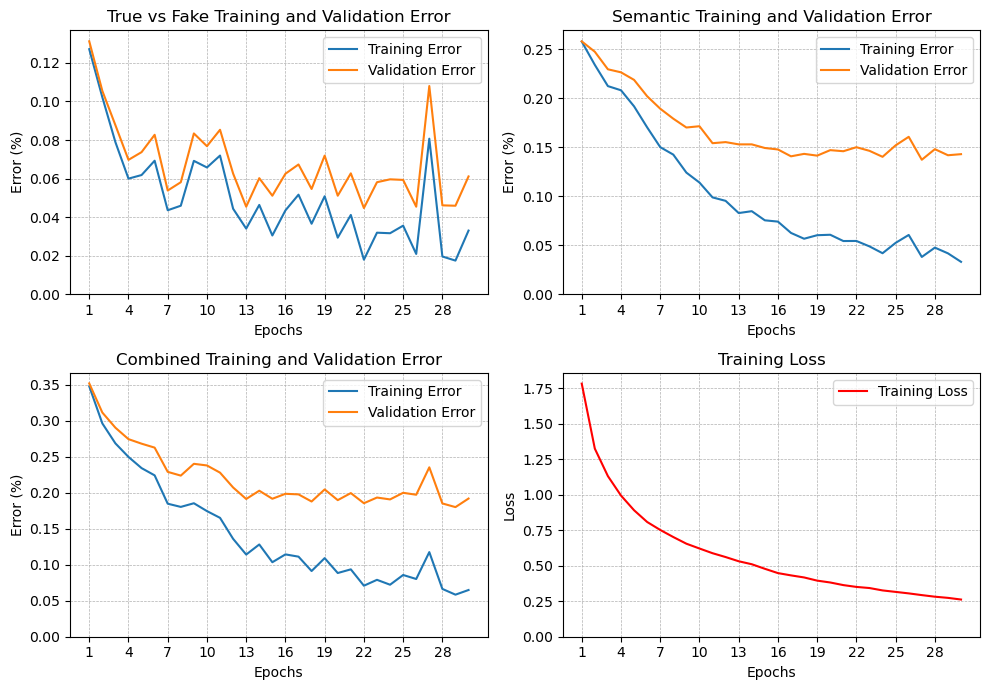



 - multioutput_lr0001_batch256_epochs30

  Epoch 1:  
        Train error: Combined=17.22%; Binary=3.27%; Semantic=14.63%; 
        Validation error: Combined=20.62%; Binary=4.56%; Semantic=17.06%; 
        Loss: 1.2138
  Epoch 2:  
        Train error: Combined=11.57%; Binary=2.26%; Semantic=9.53%; 
        Validation error: Combined=17.35%; Binary=3.82%; Semantic=14.29%; 
        Loss: 0.5606
  Epoch 3:  
        Train error: Combined=7.67%; Binary=1.04%; Semantic=6.74%; 
        Validation error: Combined=16.28%; Binary=3.48%; Semantic=13.58%; 
        Loss: 0.3977
  Epoch 4:  
        Train error: Combined=5.17%; Binary=0.90%; Semantic=4.32%; 
        Validation error: Combined=15.99%; Binary=3.52%; Semantic=13.11%; 
        Loss: 0.2890
  Epoch 5:  
        Train error: Combined=3.66%; Binary=0.55%; Semantic=3.14%; 
        Validation error: Combined=15.57%; Binary=3.39%; Semantic=12.91%; 
        Loss: 0.2118
  Epoch 10:  
        Train error: Combined=1.11%; Binary=0.21%; Sema

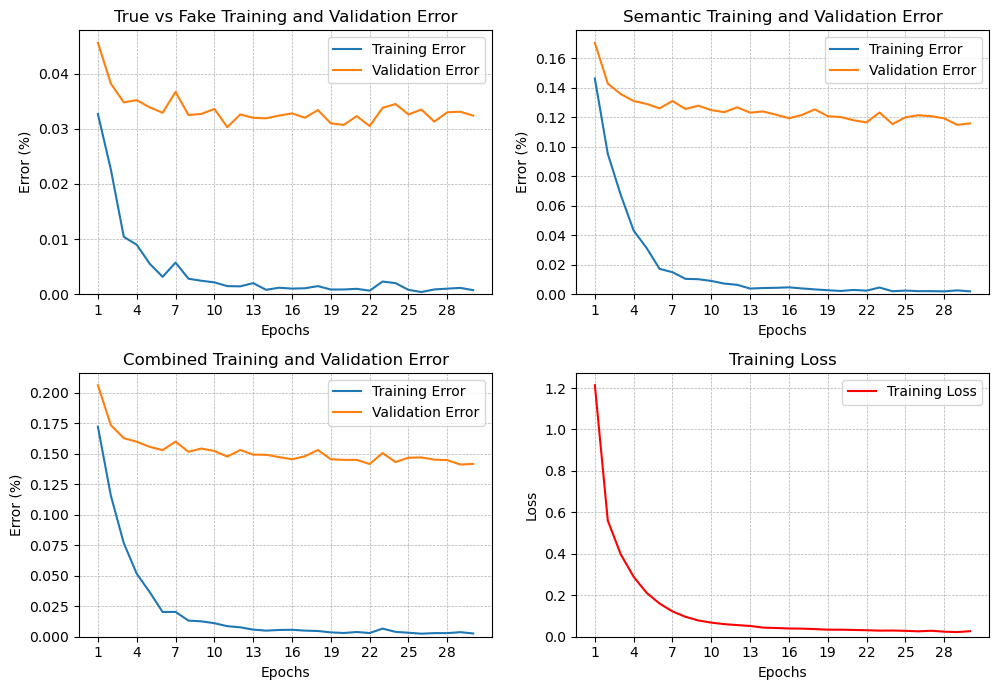



 - multioutput_lr0001_batch1024_epochs30

  Epoch 1:  
        Train error: Combined=24.78%; Binary=5.59%; Semantic=20.79%; 
        Validation error: Combined=26.64%; Binary=6.40%; Semantic=22.22%; 
        Loss: 1.6840
  Epoch 2:  
        Train error: Combined=15.84%; Binary=2.77%; Semantic=13.54%; 
        Validation error: Combined=20.37%; Binary=4.32%; Semantic=16.98%; 
        Loss: 0.7230
  Epoch 3:  
        Train error: Combined=11.09%; Binary=1.61%; Semantic=9.66%; 
        Validation error: Combined=18.15%; Binary=3.87%; Semantic=15.10%; 
        Loss: 0.5155
  Epoch 4:  
        Train error: Combined=7.75%; Binary=0.98%; Semantic=6.84%; 
        Validation error: Combined=17.60%; Binary=3.79%; Semantic=14.59%; 
        Loss: 0.3806
  Epoch 5:  
        Train error: Combined=4.82%; Binary=0.50%; Semantic=4.35%; 
        Validation error: Combined=16.80%; Binary=3.75%; Semantic=13.79%; 
        Loss: 0.2762
  Epoch 10:  
        Train error: Combined=0.56%; Binary=0.09%; S

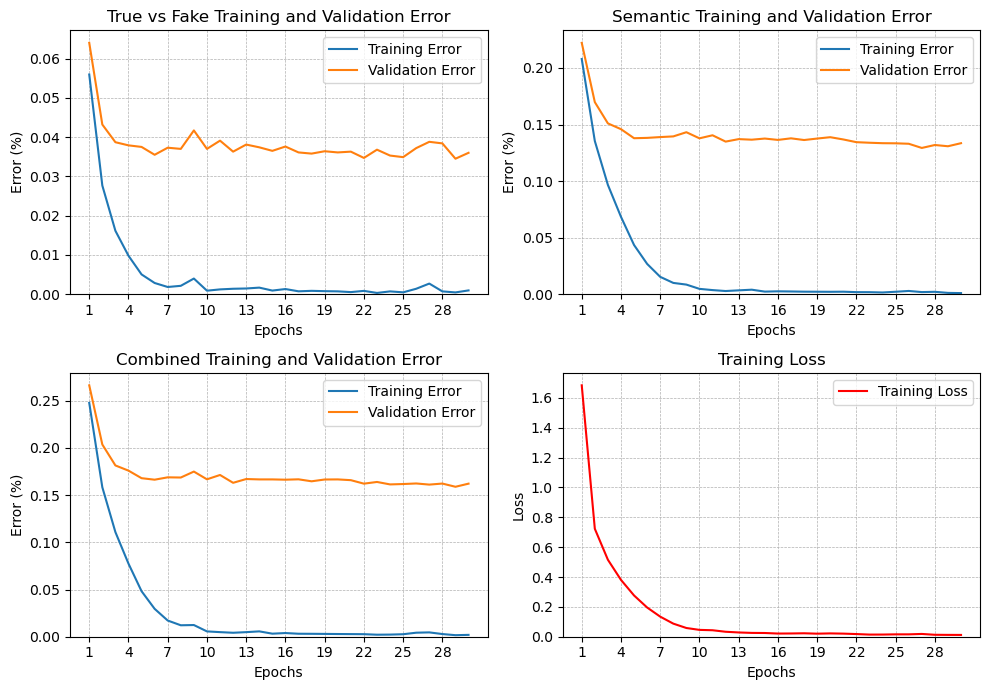



 - multioutput_lr-05_batch4_epochs30

  Epoch 1:  
        Train error: Combined=48.53%; Binary=14.74%; Semantic=40.10%; 
        Validation error: Combined=49.08%; Binary=15.37%; Semantic=40.36%; 
        Loss: 2.2826
  Epoch 2:  
        Train error: Combined=36.06%; Binary=10.07%; Semantic=29.35%; 
        Validation error: Combined=36.78%; Binary=10.83%; Semantic=29.46%; 
        Loss: 1.7842
  Epoch 3:  
        Train error: Combined=32.91%; Binary=11.84%; Semantic=24.72%; 
        Validation error: Combined=33.07%; Binary=12.03%; Semantic=24.63%; 
        Loss: 1.5844
  Epoch 4:  
        Train error: Combined=28.57%; Binary=7.99%; Semantic=22.75%; 
        Validation error: Combined=28.69%; Binary=7.87%; Semantic=23.06%; 
        Loss: 1.4557
  Epoch 5:  
        Train error: Combined=26.91%; Binary=7.82%; Semantic=21.03%; 
        Validation error: Combined=27.39%; Binary=7.97%; Semantic=21.41%; 
        Loss: 1.3562
  Epoch 10:  
        Train error: Combined=21.89%; Binary=

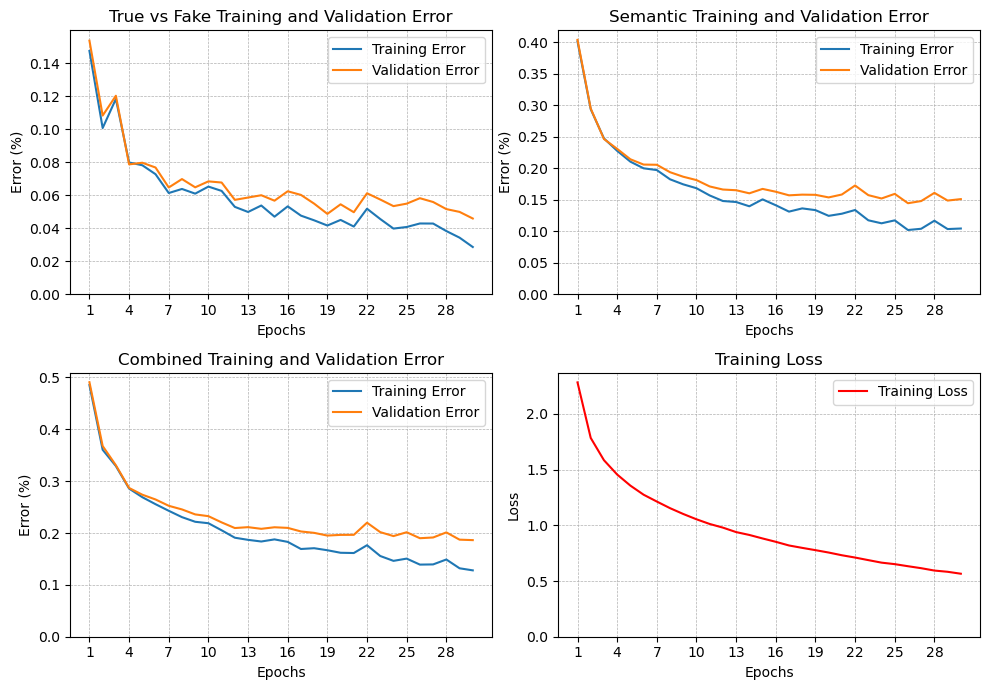



 - multioutput_lr-05_batch256_epochs30

  Epoch 1:  
        Train error: Combined=55.27%; Binary=15.08%; Semantic=47.80%; 
        Validation error: Combined=55.90%; Binary=15.77%; Semantic=48.73%; 
        Loss: 2.6572
  Epoch 2:  
        Train error: Combined=37.05%; Binary=8.92%; Semantic=31.53%; 
        Validation error: Combined=38.14%; Binary=9.46%; Semantic=32.44%; 
        Loss: 1.6892
  Epoch 3:  
        Train error: Combined=28.91%; Binary=6.27%; Semantic=24.57%; 
        Validation error: Combined=30.65%; Binary=6.89%; Semantic=25.88%; 
        Loss: 1.1891
  Epoch 4:  
        Train error: Combined=24.28%; Binary=4.84%; Semantic=20.74%; 
        Validation error: Combined=26.48%; Binary=5.99%; Semantic=22.21%; 
        Loss: 0.9614
  Epoch 5:  
        Train error: Combined=21.30%; Binary=3.96%; Semantic=18.29%; 
        Validation error: Combined=24.31%; Binary=5.43%; Semantic=20.37%; 
        Loss: 0.8309
  Epoch 10:  
        Train error: Combined=12.69%; Binary=1.

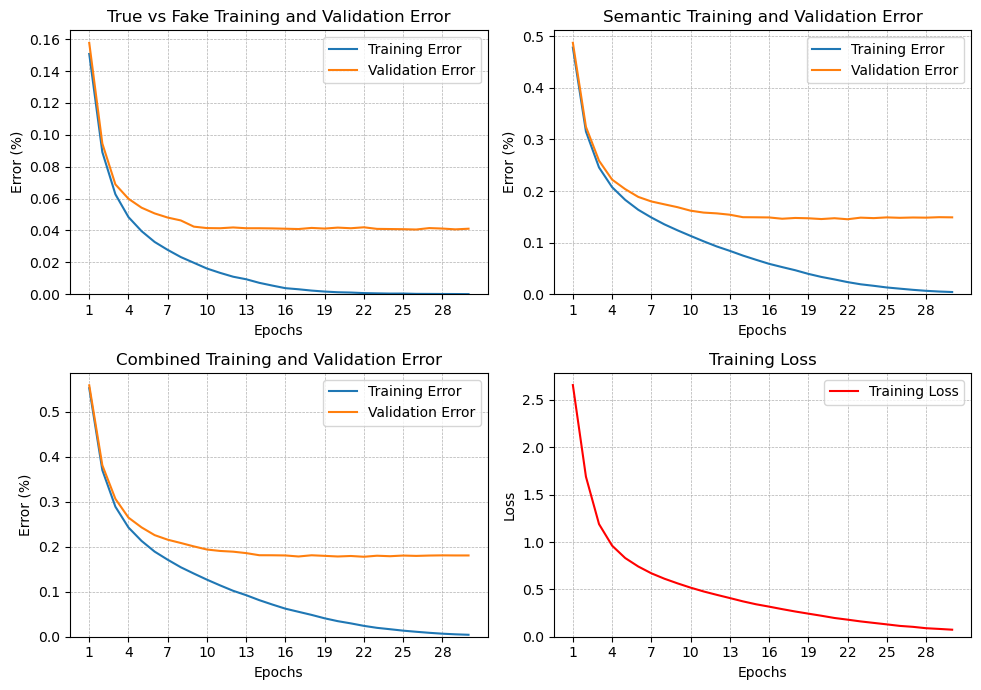



 - multioutput_lr-05_batch1024_epochs30

  Epoch 1:  
        Train error: Combined=72.96%; Binary=24.78%; Semantic=65.19%; 
        Validation error: Combined=73.53%; Binary=25.26%; Semantic=65.90%; 
        Loss: 2.9242
  Epoch 2:  
        Train error: Combined=56.88%; Binary=16.10%; Semantic=49.24%; 
        Validation error: Combined=57.16%; Binary=17.05%; Semantic=49.55%; 
        Loss: 2.4615
  Epoch 3:  
        Train error: Combined=45.77%; Binary=11.91%; Semantic=39.01%; 
        Validation error: Combined=46.85%; Binary=12.82%; Semantic=39.70%; 
        Loss: 1.9798
  Epoch 4:  
        Train error: Combined=38.99%; Binary=9.47%; Semantic=33.22%; 
        Validation error: Combined=40.80%; Binary=10.25%; Semantic=34.64%; 
        Loss: 1.5974
  Epoch 5:  
        Train error: Combined=33.82%; Binary=7.82%; Semantic=28.75%; 
        Validation error: Combined=35.80%; Binary=8.72%; Semantic=30.23%; 
        Loss: 1.3308
  Epoch 10:  
        Train error: Combined=21.64%; Bin

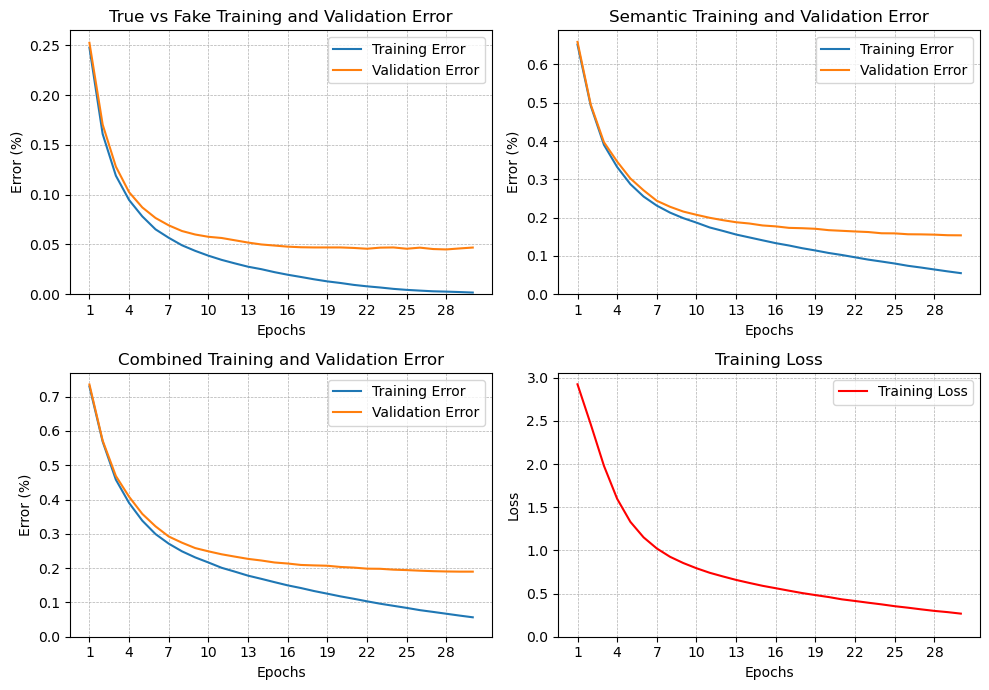

In [6]:
epochs = 30
learning_rates = [0.0001, 0.00001]
batch_sizes = [4, 256, 1024]

for lr in learning_rates:
    for batch_size in batch_sizes:
        train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
        val_dl = DataLoader(validation_ds, batch_size=1000)

        # Load the pretrained ResNet18 model
        pretrained_model = resnet18(weights=ResNet18_Weights.DEFAULT)
        # Instantiate the custom model
        model = MultioutputResNet18(pretrained_model)
        model = model.to(device)

        opt = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=lr)

        print(f"\n\n - multioutput_lr{str(lr-int(lr))[2:]}_batch{batch_size}_epochs{epochs}\n")

        train_errors, val_errors, train_loss = train_network_multioutput(opt, model, device, epochs, train_dl, val_dl)

        plot_accuracies_multioutput(train_errors, val_errors, train_loss)

        torch.save(model.state_dict(), f'./weights/multioutput_lr{str(lr-int(lr))[2:]}_batch{batch_size}_epochs{epochs}.pth')
